In [1]:
import pandas as pd
import os
from anndata import AnnData, read_h5ad
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import anndata2ri
anndata2ri.activate()
from anndata import AnnData
from typing import Union

from scipy.sparse import csr_matrix, csc_matrix

import warnings
warnings.filterwarnings("ignore")

sns.set_color_codes()

/tmp/ipykernel_3799/2680056260.py:14: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
# Load count matrix from CSV file
data_dir = os.path.expanduser("./")
csv_file = os.path.join(data_dir, "filtered.SF.df.csv")
h5_file = os.path.join(data_dir, "adata.h5ad")

# Function to load csv file into anndata object - only called if the adata object has not already been saved as .h5ad
def load_csv_data() -> AnnData:
    """
    Process publicly available data files into usable anndata object. On my machine this runs in about 100 seconds.
    """
    df = pd.read_csv(csv_file, index_col=0, header=0)
    obs_names = df.columns
    var_names = df.index
    # Compress matrix into sparse representation
    X = csc_matrix(df.to_numpy()).transpose()
    
    var = pd.DataFrame(index=var_names)
    obs = pd.DataFrame(index=obs_names)
    adata = AnnData(X=X, var=var, obs=obs)

    del df

    # Load cluster annotations from separate file
    with open("data.xlsx", 'rb') as file:
        annotation_df = pd.read_excel(file, sheet_name="Cluster annotation-Fig1B-C", header=0, index_col=0)
    annotation_df['Cluster number'] = pd.Categorical(annotation_df['Cluster number'].astype(np.int_))
    cluster_names = {
        1: "B-cell",
        2: "Plasma cell",
        3: "Monocyte/Macrophage",
        4: "Dendritic cell",
        5: "Lymphocyte",
        6: "Exhausted CD8+ T-cell",
        7: "Regulatory T-cell",
        8: "Cytotoxicity (Lymphocytes)",
        9: "Exhausted/HS CD8+ T-cell",
        10: "Memory T-cell",
        11: "Lymphocytes exhausted/cell-cycle"
    }
    annotation_df['group'] = annotation_df['Cluster number'].map(cluster_names)

    # Remove some extra tags from the labels here
    annotation_df.index = [v.removesuffix("_DP1").removesuffix("_DP").removesuffix("_DN") for v in annotation_df.index]

    # This splits the based on a '_' delimiter (first entry is pre vs post, second is patient ID, remainder is cell name + other stuff)
    obs_data = [v.split('_') for v in list(obs_names)]
    # Massage the cell name out of the remaining stuff
    pre_post = [v[0] for v in obs_data]
    patient = [v[1] for v in obs_data]
    cell_name = ['_'.join(v[2:]).removeprefix("2_").removesuffix('_myeloid_enriched').replace('.', '-') for v in obs_data]
    ind1 = [v.removesuffix("_T_enriched") for v in cell_name]
    duplicate_prefix = {item for item, count in Counter(ind1).items() if count > 1}
    cell_name = [v.replace('_T_enriched', "_DN1") if v.removesuffix("_T_enriched") in duplicate_prefix 
                    else v.removesuffix("_T_enriched") for v in cell_name]
    annotation_df.index = [v.removesuffix("_DN1") if v.removesuffix("_DN1") not in duplicate_prefix else v for v in annotation_df.index]

    # Assign column names and convert to categorical
    obs_data = {
        "pre_post": pre_post,
        "patient": patient,
        "label": obs_names
    }

    # Convert to dataframe and write into adata
    data_df = pd.DataFrame(obs_data, index=cell_name)
    obs_df = data_df.join(annotation_df)
    adata.obs = obs_df

    # Basic pre-analysis
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)
    sc.pp.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    # Cache for later
    adata.write_h5ad(h5_file)
    
    return adata

try:
    # Uncomment to force regeneration from original files
    #raise FileNotFoundError
    adata = read_h5ad(h5_file)
except (FileNotFoundError, OSError) as e:
    adata = load_csv_data()

In [3]:
def save_data_as_rds(adata: AnnData, savename: str, group_by: str = "class"):
    # converter does not currently seem to support sparse matrix entries
    adata = adata.copy()
    try:
        adata.X = adata.X.todense()
    except AttributeError:
        pass

    # get rid of extraneous columns that may not convert properly anyway
    adata.obs = adata.obs.loc[:, [group_by]]

    robjects.r('''
                f <- function(s, pos=NULL) {
                    library(CellChat)
                    assay(s, "logcounts") = assay(s, "X")

                    cellchat <- createCellChat(object = s, group.by = "%s")

                    saveRDS(cellchat, "%s")
                }
            ''' %(group_by, savename))


    robjects.r['f'](adata)

In [4]:
# In order to be able to analyze the pre and post treatment groups separately
adata_pre = adata[adata.obs['pre_post'] == 'Pre'].copy()
adata_post = adata[adata.obs['pre_post'] == 'Post'].copy()

In [5]:
adata_pre.shape

(3795, 55737)

In [6]:
save_data_as_rds(adata_pre, "cellchat_pre.rds", group_by="group")

In [7]:
save_data_as_rds(adata_post, "cellchat_post.rds", group_by="group")

In [8]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

x = adata_pre[adata_pre.obs.group == "Memory T-cell", :].X.toarray()
y = adata_post[adata_post.obs.group == "Memory T-cell", :].X.toarray()
_, p = mannwhitneyu(x=x, y=y)
print(p.shape)

(55737,)


In [9]:
p = pd.Series(p, index=adata.var_names)

In [10]:
commprob = pd.read_csv("commprob_fc.csv", index_col=0, header=0, usecols=[1, 2])
commprob

,log2(fc)
ligand,
CXCL2,4.797643
NEGR1,4.380113
C3,2.825721
SPP1,2.578302
CCL20,2.446743
...,...
KITLG,-2.771640
NFASC,-3.336903
NCAM1,-4.009729


In [11]:
p = p[commprob.index]
commprob['-log10(p)'] = -np.log10(p)

In [12]:
def volcano(
    df,
    interaction=None,
    gene_list=None,
    ax=None,
    show=True,
    xlim=None,
    ylim=None,
    axis_labels=True,
    fc_cutoff=0,
    p_cutoff=2,
    fontsize=None,
    xoffset=0,
    yoffset=0.5,
    marker=None,
    title=None,
    **kwargs,
):
    if interaction is not None:
        # filter out the actual genes from the interaction
        ligand, receptor = interaction.split("_")
        ligand = ligand.capitalize()
        receptor = receptor.capitalize()
        df = df.drop(index=ligand).drop(index=receptor)
    x = df["log2(fc)"]
    y = df["-log10(p)"]

    # for coloring points based on significance
    hue = np.zeros(shape=x.shape)
    hue[np.logical_and(x > fc_cutoff, y > p_cutoff)] = 1
    hue[np.logical_and(x < -fc_cutoff, y > p_cutoff)] = 2
    palette = []
    if 0 in hue:
        palette.append(sns.color_palette("muted")[7])
        # palette.append("gray")
    if 1 in hue:
        palette.append(sns.color_palette("muted")[3])
        # palette.append("red")
    if 2 in hue:
        palette.append(sns.color_palette("muted")[0])
        # palette.append("blue")

    # For indicating a subset of genes using a different marker
    style = None
    if marker is not None:
        style = np.zeros(len(x), dtype=np.int32)
        for idx in range(len(x)):
            style[idx] = df.index[idx] in marker

    ax = sns.scatterplot(
        x=x,
        y=y,
        hue=hue,
        palette=palette,
        legend=None,
        ax=ax,
        style=style,
        markers=["o", "^"],
        **kwargs,
    )

    for i, row in df.iterrows():
        x = row["log2(fc)"]
        y = row["-log10(p)"]
        if gene_list is not None and (gene_list is True or i in gene_list):
            # gene_list can be either a list or a dictionary containing offsets
            try:
                gene_xoffset, gene_yoffset = gene_list[i]
            except TypeError:
                gene_xoffset, gene_yoffset = xoffset, yoffset
            ax.text(
                x + gene_xoffset,
                y + gene_yoffset,
                i,
                fontsize=fontsize,
                horizontalalignment="right",
            )

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    if not axis_labels:
        ax.set_xlabel("")
        ax.set_ylabel("")
    else:
        ax.set_xlabel("log2(fc)", size=fontsize)
        ax.set_ylabel("-log10(p)", size=fontsize)
    plt.xticks(size=fontsize)
    plt.yticks(size=fontsize)

    # TODO: titles
    if title is not None:
        ax.set_title(title)
    elif interaction is not None:
        ax.set_title(" - ".join([v.capitalize() for v in interaction.split("_")]))
    if show:
        plt.show()

    return ax

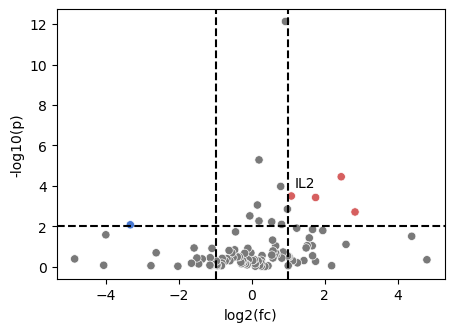

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[5, 3.5])
volcano(commprob, ax=ax, fc_cutoff=1, show=False, gene_list="IL2")
ax.axhline(y=2.0, color="black", ls='--')
ax.axvline(x=1.0, color="black", ls='--')
ax.axvline(x=-1.0, color="black", ls='--')
#fig.savefig("volcano.pdf", dpi=300, transparent=True, bbox_inches="tight")